# Pseudo-Hamiltonian neural networks

In this notebook, we will give an example of how to setup and train a neural network on simple harmonic oscillating spring with dissipation using `phlearn`. We will also demonstrate how to add an external force to the system, which can also be learnt by the pseudo-hamiltonian framework. 

For details, see ["Pseudo-Hamiltonian Neural Networks with State-Dependent
External Forces"](https://arxiv.org/abs/2206.02660).

In [1]:
# Uncomment for local install: 
# %pip install -e ../phlearn 

In [2]:
import numpy as np
import torch
import phlearn.phsystems as phsys
import phlearn.phnns as phnn
import matplotlib.pyplot as plt

ttype = torch.float32
torch.set_default_dtype(ttype)


#### Set up the system

Below is an example of how to set up a Hamiltonian system with linear dissipation using the PseudoHamiltonianSystem() class. The below block sets up the differential equation that will be used to generate the data. Initially, we will just create a simple harmonic oscilator with damping. 

In [3]:
nstates = 2


def setup_spring_system(
    mass=1.0, spring_constant=1.0, damping=0.3, external_forces=None
):
    R = np.diag([0, damping])
    M = np.diag([spring_constant / 2, 1 / (2 * mass)])

    def hamiltonian(x):
        return x.T @ M @ x

    def hamiltonian_grad(x):
        return 2 * M @ x

    spring_system = phsys.PseudoHamiltonianSystem(
        nstates=nstates,
        hamiltonian=hamiltonian,
        grad_hamiltonian=hamiltonian_grad,
        dissipation_matrix=R,
        external_forces=external_forces,
    )

    return spring_system


spring_system = setup_spring_system()


#### Generate training data

Use the `spring_system` instance to generate training data, which are numerical solutions to the exact ODE.  

In [4]:
def get_training_data(data_points=30000, dt=0.1, tmax=10):
    nt = round(tmax / dt)
    t_axis = np.linspace(0, tmax, nt + 1)
    ntrajectories_train = int(np.ceil(data_points / nt))
    traindata = phnn.generate_dataset(spring_system, ntrajectories_train, t_axis)
    return traindata, t_axis


traindata, t_axis = get_training_data()


#### Set up the pseudo Hamiltonian neural network
We create an instance of HamiltonianNN(), which is the untrained neural network used to approximate the Hamiltonian of the system. This is passed to the PseudoHamiltonianNN() class along with an instance of R_estimator(), which islearns the damping coefficient during training. 

We will allow additional keyword arguments to be passed to PseudoHamiltonianNN() so we have the option of adding an external force in the system.

In [5]:
def setup_pseudo_hamiltonian_nn(**kwargs):
    states_dampened = np.diagonal(spring_system.dissipation_matrix) != 0
    phmodel = phnn.PseudoHamiltonianNN(
        nstates,
        dissipation_est=phnn.R_estimator(states_dampened),
        **kwargs,
    )
    return phmodel


phmodel = setup_pseudo_hamiltonian_nn()


#### Setup a baseline model
To compare against PseudoHamiltonianNN() , we will create a baseline model which will approximate the dynamics using a standard fully connected multilayer perceptron. 

In [6]:
def setup_baseline_nn(hidden_dim=100):
    baseline_nn = phnn.BaselineNN(nstates, hidden_dim)
    basemodel = phnn.DynamicSystemNN(nstates, baseline_nn)
    return basemodel


basemodel = setup_baseline_nn()


#### Train the models

In [7]:
def train_models(*models, epochs=30, batch_size=32, **kwargs):
    for model in models:
        model, _ = phnn.train(
            model,
            integrator="midpoint",
            traindata=traindata,
            epochs=epochs,
            batch_size=batch_size,
            **kwargs
        )
    return models


phmodel, basemodel = train_models(phmodel, basemodel)


/usr/local/Caskroom/miniforge/base/envs/phnn_pde/lib/python3.10/site-packages/torch/amp/autocast_mode.py:202: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')



Epoch 1
Training loss: 1.82e-02
Epoch training time: 1.80seconds

Epoch 2
Training loss: 3.54e-03
Epoch training time: 1.97seconds

Epoch 3
Training loss: 3.19e-03
Epoch training time: 2.59seconds

Epoch 4
Training loss: 2.67e-03
Epoch training time: 2.11seconds

Epoch 5
Training loss: 1.16e-03
Epoch training time: 1.93seconds

Epoch 6
Training loss: 2.5e-04
Epoch training time: 1.80seconds

Epoch 7
Training loss: 2.26e-04
Epoch training time: 1.88seconds

Epoch 8
Training loss: 2.26e-04
Epoch training time: 1.86seconds

Epoch 9
Training loss: 2.04e-04
Epoch training time: 1.93seconds

Epoch 10
Training loss: 1.95e-04
Epoch training time: 2.1seconds

Epoch 11
Training loss: 1.87e-04
Epoch training time: 2.3seconds

Epoch 12
Training loss: 1.78e-04
Epoch training time: 2.19seconds

Epoch 13
Training loss: 1.72e-04
Epoch training time: 2.40seconds

Epoch 14
Training loss: 1.78e-04
Epoch training time: 2.29seconds

Epoch 15
Training loss: 1.78e-04
Epoch training time: 2.27seconds

Epoch 

#### Plot the results

In this cell we compare the learned damping constant against the true value and compare some trajectories against the exact solution. 

true damping constant   : 0.3         
learned damping constant: 0.3027031123638153


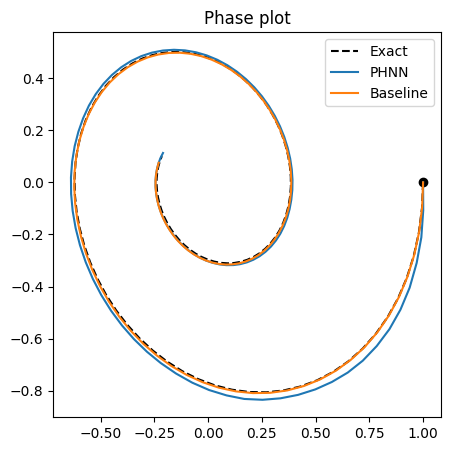

In [8]:
def print_damping_constants():
    learned_damping_constant = phmodel.R().detach().numpy()[1, 1]
    true_damping_constant = spring_system.dissipation_matrix[1, 1]
    print(
        f"true damping constant   : {true_damping_constant} \
        \nlearned damping constant: {learned_damping_constant}"
    )


def get_trajectories(x0, t_axis):
    x_exact, *_ = spring_system.sample_trajectory(t_axis, x0=x0)
    x_phnn, _ = phmodel.simulate_trajectory(integrator=False, t_sample=t_axis, x0=x0)
    x_baseline, _ = basemodel.simulate_trajectory(
        integrator=False, t_sample=t_axis, x0=x0
    )
    return x_exact, x_phnn, x_baseline


def plot_trajectories(x_exact, x_phnn, x_baseline):
    plt.figure(figsize=(5, 5))
    plt.plot(x_exact[:, 0], x_exact[:, 1], color="k", linestyle="dashed", label="Exact")
    plt.plot(x_exact[0, 0], x_exact[0, 1], "ko")
    plt.plot(x_phnn[:, 0], x_phnn[:, 1], label="PHNN")
    plt.plot(x_baseline[:, 0], x_baseline[:, 1], label="Baseline")
    plt.legend()
    plt.title("Phase plot")
    plt.show()


x_exact, x_phnn, x_baseline = get_trajectories(x0=[1, 0], t_axis=t_axis)
print_damping_constants()
plot_trajectories(x_exact, x_phnn, x_baseline)


### Learning an external force
Here we will repeat the above process with the inclusion of an external force on the spring system. 

First we define the external force `F` that will be used to instantiate the `PseudoHamiltonianSystem` class. Next, we construct a neural network to learn this force using `ExternalForcesNN`, which is used to instantiate the `PseudoHamiltonianNN` class. 

In [9]:
def F(x, t):
    f0 = 0.5
    omega = np.pi / 2
    return np.array([0, f0 * np.sin(omega * t)])


ext_forces_nn = phnn.ExternalForcesNN(
    nstates=nstates,
    noutputs=1,  # force affects one state variable only, specified by the parameter external_forces_filter
    external_forces_filter=[
        0,
        1,
    ],  # tells the NN to give output only in the second dimension
    hidden_dim=100,
    timedependent=True,
    statedependent=False,  # force depends on time only
)


Now we will repeat the setup, data generation and training steps with external forces. 

In [10]:
spring_system = setup_spring_system(external_forces=F)
phmodel = setup_pseudo_hamiltonian_nn(external_forces_est=ext_forces_nn)
basemodel = setup_baseline_nn()
traindata, t_axis = get_training_data(dt=0.1, tmax=10, data_points=50000)
phmodel, basemodel = train_models(phmodel, basemodel)
x_exact, x_phnn, x_baseline = get_trajectories(x0=[1, 0], t_axis=t_axis)
print_damping_constants()
plot_trajectories(x_exact, x_phnn, x_baseline)


ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (2,) + inhomogeneous part.